In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
import os
import nibabel as nib
import SimpleITK as sitk
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from skimage.transform import resize
from tqdm import tqdm

In [2]:
a = np.array([[0,2.0,9.0],[3.0,4.0,10.0],[1.0,2.0,9.0]])
b = np.array([[5,6,1],[66,7,5],[1,2,9]])
d = np.array([[5,6,1],[66,7,5],[1,2,9]])

In [3]:
h = np.stack((a,b,d,d))

print(h)

[[[ 0.  2.  9.]
  [ 3.  4. 10.]
  [ 1.  2.  9.]]

 [[ 5.  6.  1.]
  [66.  7.  5.]
  [ 1.  2.  9.]]

 [[ 5.  6.  1.]
  [66.  7.  5.]
  [ 1.  2.  9.]]

 [[ 5.  6.  1.]
  [66.  7.  5.]
  [ 1.  2.  9.]]]


In [4]:
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")
bb_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")

In [16]:
def load_image(path):
    img = pydicom.read_file(path)
    img = img.pixel_array
    return resize(img[:,20:-20], (100, 60))

In [17]:
def window(img):
    img[np.where(img<0)] = 0
    mean = img.mean()
    std = img.std()
    img[np.where(img>(mean+(3*std)))] = (mean+(3*std))
    img = img-img.min()
    maxx = img.max()
    img[np.where(img<(maxx/2))] = maxx/2
    img = (img-(maxx/2)) / (maxx/2)
    return img

In [52]:
for p in tqdm(os.listdir("../input/rsna-2022-cervical-spine-fracture-detection/train_images")):
    path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/"+p+"/"
    len10percent = len(os.listdir(path))//10
    final_ct = window(load_image(path+"30.dcm")).reshape(100,60,1)
    for image in range(len10percent, len(os.listdir(path))-len10percent):
        img = window(load_image(path+str(image)+".dcm")).reshape(100,60,1)
        final_ct = np.append(final_ct, img, axis=-1)
    resized_final_ct = cv2.resize(final_ct[:,0,:], (100,100)).reshape(100,100,1)
    for i in range(1,final_ct.shape[1]):
        resized_final_ct = np.append(resized_final_ct, cv2.resize(final_ct[:,i,:], (100,100)).reshape(100,100,1), axis=-1)
    ni_img = nib.Nifti1Image(resized_final_ct, affine=np.eye(4))
    nib.save(ni_img, str(p) + ".nii.gz")

  0%|          | 3/2019 [00:23<4:20:53,  7.76s/it]


RuntimeError: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. GDCM), pylibjpeg (req. )

In [43]:
resized_final_ct.shape

(100, 100, 60)

In [46]:
ni_img = nib.Nifti1Image(resized_final_ct, affine=np.eye(4))
nib.save(ni_img, "dicom_volume_image.nii")

In [47]:
img = nib.load("./dicom_volume_image.nii")

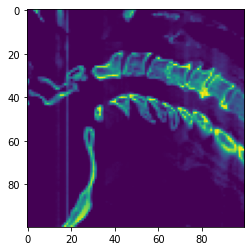

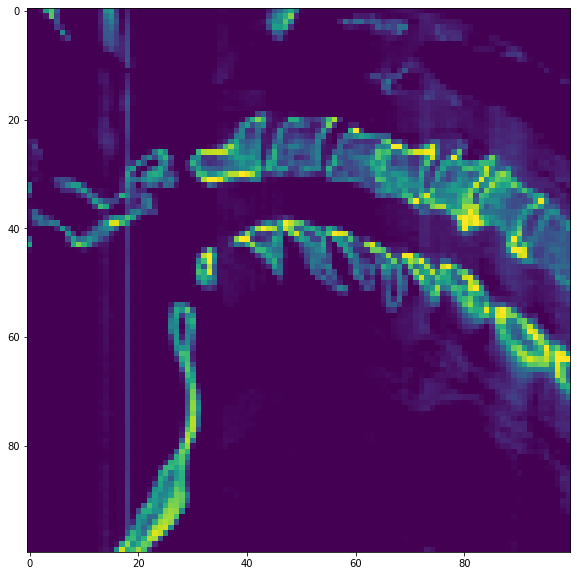

In [44]:
plt.figure(figsize = (10,10))
plt.imshow(resized_final_ct[:,:,30])

0.0